**The action space here are the variables themselves. At each step we only look at values from the regressor for variables that are still available**

In [2]:
%matplotlib inline

from collections import defaultdict
from queue import Queue

import matplotlib.pyplot as plt
import numpy as np
import os

import pickle
import time

from random import shuffle
from itertools import combinations
from scipy.special import comb

In [3]:
switch_literal = lambda x: x[1:] if x.startswith('-') else '-'+x
deepcopy = lambda x: pickle.loads(pickle.dumps(x))

def parse_input(input_file):
    
    """
    literal_clauseNum: {Literal: Set of clause numbers that are still in consideration for this variable}                        
    
    clauseNum_clause: {Clause number: Set of literals that could still satisfy this clause}
    
    literal_boolen: {Literal: boolean on whether literal set of True/False/None, None meaning could be either, doesn't matter}
    
    input_file:
    c DIMACS CNF: conjunction/AND of one or more clauses, where a clause is a disjunction/OR of literals
    c Comments start with a c, First lines begins with p and describes the probelm and all clause lines end with a 0
    c Can't have same variable in both forms in same clause. So A ~A is not allowed. Can have them in separate clauses.
                        
    """

    all_clauses = []  # List of all clauses that appear in input. Used for SAT checking the mapping given by DPLL

    literal_clauseNum = defaultdict(set)

    def filler():
        return None

    literal_boolen = defaultdict(filler)

    clauseNum_clause = {}

    clause_counter = 0

    with open(input_file, 'r') as fin:
        for line in fin:
            line = line.strip()
            # Do checks on comments
            if line.startswith('c') or line.startswith('p') or line.startswith('0') or line.startswith('%'):
                continue
            if len(line) > 0:
                clause = []
                clause_counter += 1
                for literal in line.split():
                    if literal == '0':
                        # End of line, ignore in DIMACS CNF format
                        continue
                    clause.append(literal)
                    literal_clauseNum[literal].add(clause_counter)
                clauseNum_clause[clause_counter] = set(clause)
                all_clauses.append(clause)

    return literal_clauseNum, clauseNum_clause, literal_boolen, all_clauses

def unit_prop(literal_clauseNum, clauseNum_clause, literal_boolen):
    keep_updating = True
    while keep_updating:
        keep_updating = False # Assuming we've found all unit clauses
        for clauseNum in list(clauseNum_clause.keys()):
            if clauseNum not in clauseNum_clause:
                continue
            clause = clauseNum_clause[clauseNum]
            # Clause contains the remaining literals that could potentially satisfy this clause. 
            if len(clause) == 0:
                # Empty clause, so need to return True for empty clause detected
                return True, None, None, None
            if len(clause) > 1:
                # Can't do unit prop 
                continue

            literal = clause.pop()  # Needs to be set to True
            clause.add(literal)  # Removed later
            literal_boolen[literal] = True
            keep_updating = True  # Since we found one unit clause, maybe more

    #         print(literal)
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)

            # For all clauses that have this literal, they have been satisfied now
            # 1) Gather all pairs of (literals, clauseNum) that appear in these clauses so we can remove them from literal_clauseNum
            # 2) Delete these clauses from clauseNum_clause
            pairs_to_delete = []
            for clauseNums_with_literal in literal_clauseNum[literal]:
                for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
                    pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

    #         print(pairs_to_delete)

            for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
                literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
                if clauseNums_with_literal in clauseNum_clause:
                    del clauseNum_clause[clauseNums_with_literal]

            # For all the clauses with opposite literal, remove the literal from the clause
            if switch_literal(literal) not in literal_clauseNum: # if the opposite variable doesn't exist, skip
                continue

            opposite_literal = switch_literal(literal)
            literal_boolen[opposite_literal] = False

            for clauseNums_with_literal in literal_clauseNum[opposite_literal]:
                clauseNum_clause[clauseNums_with_literal].discard(opposite_literal)

            literal_clauseNum[opposite_literal] = set()  # It is not watching any clauses anymore

    #         print("OPPO")
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)
        
    return False, literal_clauseNum, clauseNum_clause, literal_boolen


def pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen):
    keep_updating = True
    while keep_updating:
        keep_updating = False
        for literal in list(literal_clauseNum.keys()):
            if literal in literal_boolen:
                continue

            opposite_literal = switch_literal(literal)
            if opposite_literal not in literal_boolen: # The opposite variable has not been assigned yet
                # If it doesn't exist or it does but it doesn't have to satisfy any clauses
                if opposite_literal not in literal_clauseNum or len(literal_clauseNum[opposite_literal]) == 0:
                    # LITERAL IS A PURE LITERAL
                    keep_updating = True
                    literal_boolen[literal] = True

                    # All the clauses that literal exists in has been made true, so remove the clauses and make literal watch no clause
                    pairs_to_delete = []
                    for clauseNums_with_literal in literal_clauseNum[literal]:
                        for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
                            pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

            #         print(pairs_to_delete)

                    for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
                        literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
                        if clauseNums_with_literal in clauseNum_clause:
                            del clauseNum_clause[clauseNums_with_literal]
                        
    return literal_clauseNum, clauseNum_clause, literal_boolen


def set_var(literal, boolean, literal_clauseNum, clauseNum_clause, literal_boolen):
    literal_boolen[literal] = boolean

    if boolean == False:
        literal = switch_literal(literal)
        literal_boolen[literal] = True
    
    # Unit-prop logic below
    pairs_to_delete = []
    for clauseNums_with_literal in literal_clauseNum[literal]:
        for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
            pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

    #         print(pairs_to_delete)

    for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
        literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
        if clauseNums_with_literal in clauseNum_clause:
            del clauseNum_clause[clauseNums_with_literal]

    # For all the clauses with opposite literal, remove the literal from the clause
    if switch_literal(literal) not in literal_clauseNum: # if the opposite variable doesn't exist, skip
        return literal_clauseNum, clauseNum_clause, literal_boolen

    opposite_literal = switch_literal(literal)
    literal_boolen[opposite_literal] = False

    for clauseNums_with_literal in literal_clauseNum[opposite_literal]:
        clauseNum_clause[clauseNums_with_literal].discard(opposite_literal)

    literal_clauseNum[opposite_literal] = set()  # It is not watching any clauses anymore

    #         print("OPPO")
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)
    
    return literal_clauseNum, clauseNum_clause, literal_boolen

In [23]:
# Methods that are used by the Env class to get state features

def number_of_clauses(literal_clauseNum):
    """ Returns the number of clauses each of the literal is present in """
    ans = np.zeros(actions)
    for literal, clauseNums in literal_clauseNum.items():
        ans[LIT_IDX[literal]] = len(clauseNums)
    return ans


def number_of_horn_clauses(clauseNum_clause):
    """ Returns the number of horn clauses each literal is present in """
    ans = np.zeros(actions)
    for clause in clauseNum_clause.values():
        if len(clause) == 0:
            continue
        pos_literals = list(filter(lambda x: not x.startswith('-'), clause))
        if len(pos_literals) == 1:
            ans[LIT_IDX[pos_literals[0]]] += 1
            
    return ans


def pos_neg_ratio(literal_clauseNum):
    ans = np.zeros(actions)
    
    for literal, clauseNums in literal_clauseNum.items():
        opposite_literal = switch_literal(literal)
        if opposite_literal in literal_clauseNum and len(literal_clauseNum[opposite_literal]) > 0:
            ratio = len(clauseNums) / len(literal_clauseNum[opposite_literal])
        else:
            ratio = len(clauseNums)
            
        ans[LIT_IDX[literal]] = ratio
        
    return ans
        


def CVIG(literal_clauseNum, clauseNum_clause):
    """
    Caluse-variable incidence graph. We create a bipartite graph (a matrix) with literals in rows and clauses in columns.
    See Features_2 PDF file.
    """
    
    clauseNum_index_mapping = {}
    
    for i, clauseNum in enumerate(clauseNum_clause):
        clauseNum_index_mapping[clauseNum] = i
        
    if len(clauseNum_clause) == 0:
        return np.zeros((len(LIT_IDX), 1))
    
    graph = np.zeros((len(LIT_IDX), len(clauseNum_index_mapping)))
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            graph[LIT_IDX[literal]] [clauseNum_index_mapping[clauseNum]] = 1/len(clauseNums)
    
    return graph


def VIG(literal_clauseNum, clauseNum_clause):
    """
    Variable incidence graph.
    """
    if len(clauseNum_clause) == 0:
        return np.zeros((actions, actions))
    
    graph = np.zeros((actions, actions))
    
    for clause in clauseNum_clause.values():
        if len(clause) < 2:
            continue
        for x, y in combinations(clause, 2):
            w = 1 / (comb(len(clause), 2))  # Try combinations with replacement to add self-loops
            graph[LIT_IDX[x]][LIT_IDX[y]] = w
            graph[LIT_IDX[y]][LIT_IDX[x]] = w
            
    return graph

In [4]:
# env = Env('../Tests/SATLIB_20/uf20-026.cnf')
# print(env.reset())
# while True:
#     _, _, done = env.step(4)
#     if done:
#         break
#     print(env.get_state())
#     a, b, c = env.state
#     print(jw_2(a, b))

In [25]:
class Env:
    
    def __init__(self, input_file):
        self.input_file = input_file
        self.stack = [] # We use a stack to hold the next states to explore. i.e. we do DFS as less memory requirements than BFS
        self.state = None
    
    def reset(self):
        # Returns state
        literal_clauseNum, clauseNum_clause, literal_boolen, _ = parse_input(self.input_file)
        self.state = (literal_clauseNum, clauseNum_clause, literal_boolen)
        return self.get_state()
    
    def get_state(self):
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        
        num_clauses = number_of_clauses(literal_clauseNum)
        num_horn_clauses = number_of_horn_clauses(clauseNum_clause)
        
        pn_ratio = pos_neg_ratio(literal_clauseNum)
        
        vig_graph = VIG(literal_clauseNum, clauseNum_clause)
        vig_mean, vig_var = np.mean(vig_graph, axis=0), np.var(vig_graph, axis=0)
        
        cvig_graph = CVIG(literal_clauseNum, clauseNum_clause)
        cvig_mean, cvig_var = np.mean(cvig_graph, axis=1), np.var(cvig_graph, axis=1)
        
        state_matrix = list(zip(num_clauses, num_horn_clauses, pn_ratio, vig_var, cvig_mean, cvig_var))
#         state_matrix = list(zip(num_clauses, num_horn_clauses, cvig_mean, cvig_var))
#         state_matrix = list(zip(num_clauses, num_horn_clauses))
        return np.array(state_matrix)  # Returns a 2D array of the state matrix
    
        
    def step(self, action):
        """
        Returns: next_state_1, next_state_2, reward, done
        reward = 0 if reached a leaf node, 0 if not
        """
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        
        num_clauses_start = 0
        for clause in clauseNum_clause.values():
            if len(clause) > 0:
                num_clauses_start += 1
            else:
                # This is reached when we reached an UNSAT state in previous step and popped off another UNSAT from the stack
                isEmpty = len(self.stack) == 0
                if not isEmpty:
                    self.state = self.stack.pop()
                return None, -1, isEmpty
        
        literal = action
        
        # Set the chosen literal to be True
        literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T = \
            set_var(literal, True, deepcopy(literal_clauseNum), deepcopy(clauseNum_clause), dict(literal_boolen))
            
            
        # Set new state
        self.state = (literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T)
        
        # Set the chosen literal to be False
        literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F = \
            set_var(literal, False, literal_clauseNum, clauseNum_clause, literal_boolen)
            
        # Check that setting chosen to False hasn't made any empty clauses
        valid = True
        for clause in clauseNum_clause_F.values():
            if len(clause) == 0:
                valid = False
        
        # Add new state to stack
        if valid:
            self.stack.append((literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F))
        
        
        if clauseNum_clause_T == {} or clauseNum_clause_F == {}:  # We have satisfied
#             print("INITIAL")
            return None, 1, True
        
        
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        
        # Do unit prop
        empty_clause, literal_clauseNum, clauseNum_clause, literal_boolen = \
            unit_prop(literal_clauseNum, clauseNum_clause, literal_boolen)
            
        if empty_clause:
            isEmpty = len(self.stack) == 0
            if not isEmpty:
                self.state = self.stack.pop()
            return None, -1, isEmpty
        
        if clauseNum_clause == {}:
#             print("UNIT PROP")
            return None, 1, True
        
        # Do pure literal elimination
        literal_clauseNum, clauseNum_clause, literal_boolen = \
            pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen)
            
            
        if clauseNum_clause == {}:
#             print("PLE")
            return None, 1, True
        
        num_clauses_end = 0
        for clause in clauseNum_clause.values():
            if len(clause) > 0:
                num_clauses_end += 1
        
        if num_clauses_start > 0:
            fraction_of_clauses_removed = (num_clauses_start - num_clauses_end)/num_clauses_start
        else:
            fraction_of_clauses_removed = 0
        
        self.state = (literal_clauseNum, clauseNum_clause, literal_boolen)
                
        return None, -1 + fraction_of_clauses_removed, False

In [10]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

class Estimator():
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.model = SGDRegressor(learning_rate="constant", eta0=0.001, penalty='l2')
        self.model.partial_fit([self.featurize_state(np.zeros(state_space))], [0])
        self.scaler = StandardScaler()
        self.scaler.fit([self.featurize_state(np.zeros(state_space))], [np.zeros(state_space)])
    
    def featurize_state(self, state):
        # Needs to return a 1D array
        if use_poly:
            state = int(state)
            return np.array([state**i for i in range(1, poly_degree+1)])
        else:
            return np.array(state)
    
    def predict(self, state):
        ans = []
        for lit_state in state:
            state_feature = self.featurize_state(lit_state)
            
            if len(state_feature.shape) < 2:
                state_feature = np.expand_dims(state_feature, 0)
            
            state_feature = self.scaler.transform(state_feature) # Returns a 2D array
            q_val= self.model.predict(state_feature)[0]
            ans.append(q_val)
            
        return np.array(ans)
    
    def update(self, state, action_idx, reward):
        model = self.model
        state_feature = self.featurize_state(state[action_idx])
        
        if len(state_feature.shape) < 2:
            state_feature = np.expand_dims(state_feature, 0)
        
        self.scaler.partial_fit(state_feature)
        state_feature = self.scaler.transform(state_feature) # Returns a 2D array
        model.partial_fit(state_feature, [reward])
        
        return 0

In [11]:
def test(test_files, ϵ=1.0, estimator=None):
    """
    This method is used to either:
    
     - Run a random policy on the test data and returns the avg. reward and length per epoch (epoch runs over the test_files).
     This can be done by only passing on first two parameters (and optionally epochs for longer runs)
     
     - Run an epilon-greedy policy with the given estimator. Pass an estimator that we receive from the train() method and set 
     the ϵ value appropriately to make an epsilon-greedy policy. Runs this policy over the test_files for given number of epochs.
    
    Returns dictionary of {epoch: average reward} and {epoch: average length per episode/file}
    """
    total_reward, total_length, total_states, total_actions = 0, 0, [], []
    
    if estimator is None:
        estimator = Estimator()  # Never used if epsilon > 1
        
    policy = DQN_make_epsilon_greedy_policy(estimator, ϵ, actions)
    
    for i, filepath in enumerate(test_files):
        
        if i % 100 == 0:
            print("Testing file", i)
        
        env = Env(filepath)
        state = env.reset()
        
        while True:
            action_probs = policy(state,  env.state[0])
            action_probs = redistribute_probability(action_probs, env.state[0])

            action_idx =  np.random.choice(np.arange(len(action_probs)), p=action_probs)
            action = IDX_LIT[action_idx]
            
            _, reward, done = env.step(action)

            # Stats
            total_length += 1
            total_reward += reward
            total_actions.append(action_idx)

            if done:
                break

            state = env.get_state()

    return total_reward/len(test_files), total_length/len(test_files), np.array(total_actions) #, total_states

In [12]:
from IPython.core.debugger import set_trace

In [13]:
import random

def DQN_make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.

    Args:
        estimator: An estimator that returns q values for a given state
        nA: Number of actions in the environment.

    Returns:
        A function that takes the (sess, observation, epsilon) as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(observation, literal_clauseNum):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        
        # Make q_values of unusable actions -inf
        for literal, clauseNums in literal_clauseNum.items():
            if len(clauseNums) == 0:
                idx = LIT_IDX[literal]
                q_values[idx] = -np.inf
        
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn


def redistribute_probability(action_prob, literal_clauseNum):
    total_gained = 0
    idx_to_increase = []
    
#     for literal, clauseNums in literal_clauseNum.items():
    for literal in LIT_IDX:  # If a literal doesn't appear in the formula, then literal_clauseNum won't have it
        clauseNums = literal_clauseNum[literal]
        if len(clauseNums) == 0:
            idx = LIT_IDX[literal]
            total_gained += action_prob[idx]
            action_prob[idx] = 0
        else:
            idx_to_increase.append(LIT_IDX[literal])
            
    per_idx_inc = total_gained / len(idx_to_increase)
    
    for idx in idx_to_increase:
        action_prob[idx] += per_idx_inc
    return action_prob



def train(training_files, ϵ, epsilon_decay=0.97, discount_factor=1.0):
    total_reward, total_length = [], []
    
    estimator = Estimator()
    
    curr_length = 0
    curr_reward = 0
    
    for j, filepath in enumerate(training_files):
        """ Each file in one episode """
        
        if j % 1000 == 0:
            part = j // 1000
            epsilon_decay_j = epsilon_decay**part
            total_reward.append(curr_reward / 1000)
            total_length.append(curr_length / 1000)
            print(part, total_reward[-1], total_length[-1])

            curr_length = 0
            curr_reward = 0
            policy = DQN_make_epsilon_greedy_policy(estimator, ϵ*epsilon_decay_j, actions)

        env = Env(filepath)
        state = env.reset()

        while True:
            action_prob = policy(state,  env.state[0])
            action_prob = redistribute_probability(action_prob, env.state[0])
            action_idx = np.random.choice(np.arange(len(action_prob)), p=action_prob)
            action = IDX_LIT[action_idx]
            
            if len(env.state[0][action]) == 0:
                print("INVALID ACTION")
            
            _, reward, done = env.step(action)

            # Stats
            curr_length += 1
            curr_reward += reward

            if done:
                td_target = reward
                estimator.update(state, action_idx, td_target)
                break

            next_state = env.get_state()

            q_values = estimator.predict(next_state)
            
            # Make q_values of unusable actions -inf
            for literal, clauseNums in env.state[0].items():
                if len(clauseNums) == 0:
                    idx = LIT_IDX[literal]
                    q_values[idx] = -np.inf 
            
            td_target = reward + discount_factor * np.max(q_values)

            current_value = estimator.predict(state)[action_idx]
            td_error = td_target - current_value

            alpha = 0.8
            update_target = current_value + alpha*td_error
            estimator.update(state, action_idx, update_target)

            state = next_state

    total_reward.append(curr_reward / 1000)
    total_length.append(curr_length / 1000)
    print("Last output:", total_reward[-1], total_length[-1])
    
    return total_reward, total_length, estimator

In [26]:
use_poly = False
poly_degree = 7

numVars = 20
LITERALS = list(range(-numVars, 0))
pos_lit = list(range(1, numVars+1))
LITERALS.extend(pos_lit)
LIT_IDX = {}  # Global mapping between literal and its position in the action space
IDX_LIT = {}  # Global mapping between its position in the action space and literal

for index, var in enumerate(LITERALS):
    LIT_IDX[str(var)] = index
    IDX_LIT[index] = str(var)

actions = len(LITERALS)  # Number of actions available to use by the agent
state_space = 6          # Number of metrics for each literal

directory = '../Tests/CNFGEN_20/'  # RLSAT problems are very simple. SATLIB probelms give more interesting Q-values.
files = os.listdir(directory)
files = list(map(lambda x: os.path.join(directory, x), files))

split = int(len(files) * 0.002)
training_files = files[:split]
# shuffle(training_files)

test_files = files[70000:71000]

print("Number of training files:", len(training_files))
print("Number of test files:", len(test_files))


s = time.time()
episode_reward_train, episode_length_train, estimator = train(training_files, ϵ=0.3, epsilon_decay=0.95)
e = time.time()
print("Done training in", (round(e-s, 2)), "s")
print()
est = estimator

print("Starting Testing")
s = time.time()
episode_reward_test, episode_length_test, episode_actions = test(test_files, ϵ=0, estimator=est)
print(episode_reward_test, episode_length_test)
print(np.bincount(episode_actions))
e = time.time()
print("Done testing in", (round(e-s, 2)), "s")
print()


# s = time.time()
# episode_reward_rand, episode_length_rand, episode_actions_rand = test(test_files)
# e = time.time()
# print(np.bincount(episode_actions))
# print(episode_reward_rand, episode_length_rand)
# print("Done testing random policy in ", (round(e-s, 2)), "s")
# print()

Number of training files: 200
Number of test files: 1000
0 0.0 0.0


/home/aks73/python/Python-3.5.1/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Last output: -7.812886625487054 8.205
Done training in 78.88 s

Starting Testing
Testing file 0


KeyboardInterrupt: 

In [30]:
%debug

# sess.close()

> <ipython-input-28-4905efc10abc>(18)featurize_state()
     16         # Needs to return a 1D array
     17         if use_poly:
---> 18             state = int(state)
     19             return np.array([state**i for i in range(1, poly_degree+1)])
     20         else:

ipdb> state
array([0., 0., 0., 0., 0., 0.])
ipdb> q


In [ ]:
estimator.model.get_weights()

In [30]:
# with open('CNFGEN_20_new_action_top4Metrics.pickle', 'wb') as fout:
#         pickle.dump((episode_reward_train, episode_length_train, estimator, episode_reward_test, episode_length_test, episode_actions, episode_reward_rand, episode_length_rand, episode_actions_rand), fout)

# with open('SATLIB_50.pickle', 'rb') as fin:
#         episode_reward_train, episode_length_train, estimator, episode_reward_test, episode_length_test, episode_reward_rand, episode_length_rand = pickle.load(fin)

# with open('NewActionSpace/CNFGEN_20_40epochs_new_action_top4Metrics.pickle', 'rb') as fin:
#         episode_reward_train, episode_length_train, estimator, episode_reward_test, episode_length_test, episode_actions, episode_reward_rand, episode_length_rand, episode_actions_rand = pickle.load(fin)
        
# with open('NewActionSpace/CNFGEN_20_40epochs_new_action_top4Metrics_allValidQ.pickle', 'rb') as fin:
#         episode_reward_train2, episode_length_train, estimator, episode_reward_test2, episode_length_test2, episode_actions, episode_reward_rand, episode_length_rand, episode_actions_rand = pickle.load(fin)
        
# with open('NewActionSpace/CNFGEN_20_40epochs_new_action_top4Metrics_policyValidQ.pickle', 'rb') as fin:
#         episode_reward_train3, episode_length_train, estimator, episode_reward_test3, episode_length_test3, episode_actions, episode_reward_rand, episode_length_rand, episode_actions_rand = pickle.load(fin)


with open('CNFGEN_20_50epochs_new_action_Linear.pickle', 'rb') as fin:
    episode_reward_train, episode_length_train, episode_reward_test, episode_length_test, episode_actions, episode_reward_rand, episode_length_rand, episode_actions_rand = pickle.load(fin)


In [28]:
print("Learnt policy")
print(episode_reward_test, episode_length_test)
print(np.bincount(episode_actions))

print()
print("Random policy")
print(episode_reward_rand, episode_length_rand)
print(np.bincount(episode_actions_rand))

Learnt policy
-26.259309419259456 28.278
[644 616 595 599 579 595 634 626 602 581 600 550 618 549 598 583 582 602
 570 608 849 804 816 828 845 831 844 863 846 815 840 806 761 794 845 789
 803 799 815 754]

Random policy
-47.83761859845908 50.165
[1242 1320 1262 1294 1236 1236 1262 1262 1217 1228 1240 1213 1216 1281
 1195 1286 1233 1286 1219 1274 1308 1173 1306 1242 1265 1296 1202 1239
 1255 1242 1258 1310 1251 1242 1255 1250 1276 1259 1253 1281]


In [19]:
# print("Action coefficients:", estimator.model.coef_)

Action coefficients: [0.37034445 0.18569419 1.08822993 0.98650918]


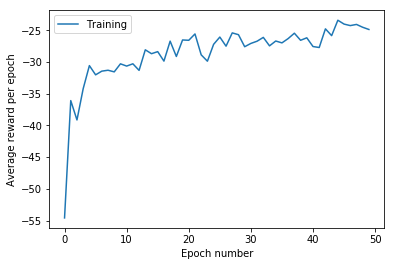

In [29]:
plt.plot(episode_reward_train[1:], label='Training')
# plt.plot(episode_reward_train2[1:], label='Max over available actions')
# plt.plot(episode_reward_train3[1:], label='Max over all actions')

# plt.plot(episode_reward_test, label='Testing')
# plt.plot(episode_reward_rand, label='Testing rand')

plt.xlabel('Epoch number')
plt.ylabel('Average reward per epoch')
# plt.ylim(-30, -20)
plt.legend()

# last_n = 10
# train_avg = np.mean(np.array(episode_reward_train)[-last_n:])
# print("Average reward for last", last_n, "epochs in training:", round(train_avg, 3))

# train_avg = np.mean(np.array(episode_reward_train2)[-last_n:])
# print("Average reward for last", last_n, "epochs in training:", round(train_avg, 3))

# train_avg = np.mean(np.array(episode_reward_train3)[-last_n:])
# print("Average reward for last", last_n, "epochs in training:", round(train_avg, 3))

# test_avg = np.mean(np.array(episode_reward_test)[-last_n:])
# print("Average reward for last", last_n, "epochs in testing:", round(test_avg, 3))

# rand_avg = np.mean(np.array(episode_reward_rand)[-last_n:])
# print("Average reward for last", last_n, "epochs in testing random policy:", round(rand_avg, 3))

# from matplotlib2tikz import save as tikz_save

# tikz_save('training_action_updates.tikz', figureheight='\\figureheight', figurewidth='\\figurewidth')


Average length for last 10 epochs in training: 21.137
Average length for last 10 epochs in testing: 23.95


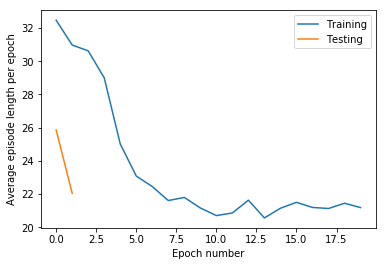

In [33]:
plt.plot(episode_length_train, label='Training')
plt.plot(episode_length_test, label='Testing')
# plt.plot(episode_length_rand, label='Testing rand')

plt.xlabel('Epoch number')
plt.ylabel('Average episode length per epoch')
plt.legend()

train_avg = np.mean(np.array(episode_length_train)[-last_n:])
test_avg = np.mean(np.array(episode_length_test)[-last_n:])
# rand_avg = np.mean(np.array(episode_length_rand)[-last_n:])

print("Average length for last", last_n, "epochs in training:", round(train_avg, 3))
print("Average length for last", last_n, "epochs in testing:", round(test_avg, 3))
# print("Average length for last", last_n, "epochs in testing random policy:", round(rand_avg, 3))

In [43]:
xs = range(100)

policy = DQN_make_epsilon_greedy_policy(estimator, 0, actions)
ys = [np.random.choice(np.arange(actions), p=policy(i)) for i in xs]

plt.scatter(xs, ys)
plt.xlabel("State")
plt.ylabel("Actions")

TypeError: 'int' object is not iterable

In [183]:
state = 256

estimator.predict(state)

array([-1.08106339, -0.98628557, -1.00681334, -1.14676465, -1.01414276,
       -1.03920674, -0.95491733, -0.97960388, -1.11900149, -0.96197248,
       -0.98531593, -0.96607036, -1.0109629 , -0.97665428, -0.99197745,
       -1.00057868, -1.02822085, -0.95329277, -0.98146715, -0.98885396,
        0.        , -0.98633782, -1.04502484, -1.07116725, -0.95054096,
       -0.96212715, -1.0541073 , -1.00578894, -0.93820797, -0.95318104,
       -1.0228148 , -1.03815234, -0.97108546, -0.96719226, -1.02232722,
       -1.0172402 , -1.03255231, -1.05948592, -1.03425613, -1.0285922 ,
       -0.97348332])

Text(0,0.5,'Q-value')

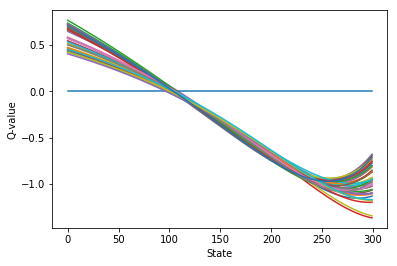

In [185]:
# plt.figure(figsize=(10, 12))

q_values = np.array([estimator.predict(s) for s in xs])

for i in range(actions):
    plt.plot(q_values[:, i], label='Action '+str(i))

# plt.legend()
plt.xlabel('State')
plt.ylabel('Q-value')

Testing time taken to use a heuristic

In [88]:
import time

heuristic = jw_2
directory = '../Tests/SATLIB_20/'
files = os.listdir(directory)
files = list(map(lambda x: os.path.join(directory, x), files))

split = int(len(files) * 0.1)
training_files = files[:split]

total_time = 0

for file in training_files:
    env = Env(file)
    env.reset()
    a, b, c = env.state
    
    s = time.time()
    for _ in range(1000):
        heuristic(a, b)
    e = time.time()
    total_time += (e - s) / 1000
    
print(total_time / split)

0.00011689195871353151


In [ ]:
{0: 'maxo', 1: 'moms', 2: 'mams', 3: 'jw', 4: 'jw_2', 5: 'bohm'}